In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Useful functions
def SaveFig(filename):
    plt.savefig(r'fig/'+filename)

In [2]:
# Wiener Process - Brownian Motion
def BrownianMotion(dt,T):
    Z = np.random.randn(int(T/dt))
    Z[0] = 0
    B = np.cumsum(dt * Z)
    return B

# Geometric Brownian Motion
def GeometricBrownianMotion(mu, sigma, x0, dt, T, B=None):
    GB = []
    if B is None:
        B = BrownianMotion(dt,T)
    for t, bt in enumerate(B):
        gbt = np.exp(np.log(x0) + (mu - 1 / 2 * sigma ** 2) * t + sigma * bt)
        GB.append(gbt)
    return GB

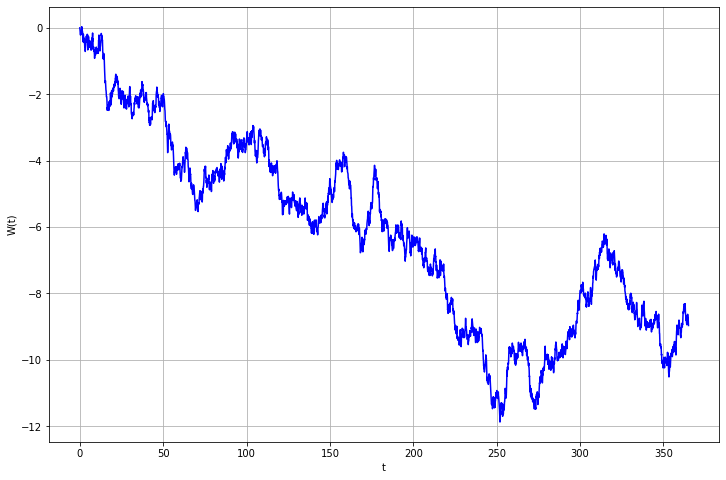

In [3]:
# Plot of Brownian Motion
dt = 0.1
T = 365

x = np.linspace(0,T,int(T/dt))
BM = BrownianMotion(dt,T)

plt.figure(figsize=(12,8))
plt.plot(x, BM, color='blue')
plt.xlabel('t')
plt.ylabel('W(t)')
plt.grid()
plt.show()

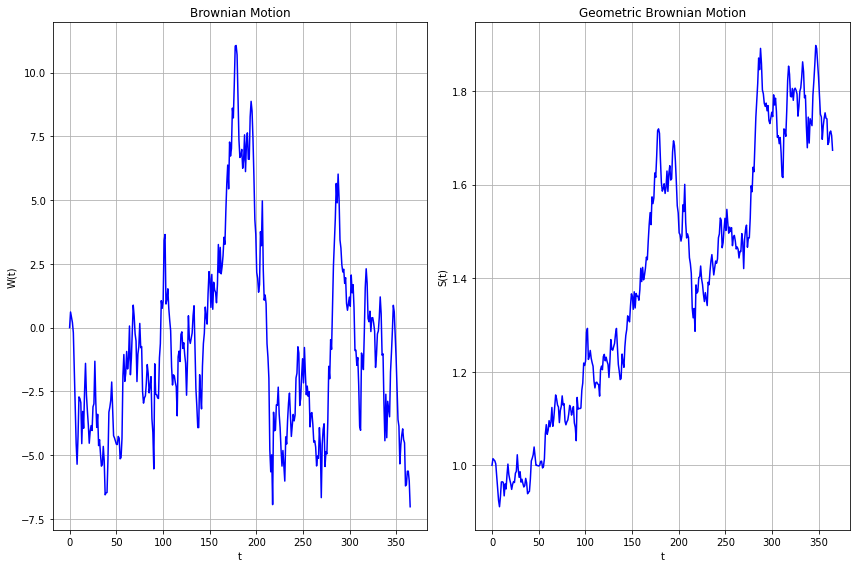

In [17]:
# Comparison between BM and GBM with the same Wiener process
mu = 0.002
sigma = 0.02
x0 = 1
dt = 1
T = 365

x = np.linspace(0,T,int(T/dt))
BM = BrownianMotion(dt,T)
GBM = GeometricBrownianMotion(mu,sigma,x0,dt,T,BM)

plt.figure(figsize=(12,8))

plt.subplot(1, 2, 1)
plt.plot(x, BM, color='blue')
plt.grid()
plt.xlabel('t')
plt.ylabel('W(t)')
plt.title('Brownian Motion')

plt.subplot(1, 2, 2)
plt.plot(x, GBM, color='blue')
plt.grid()
plt.xlabel('t')
plt.ylabel('S(t)')
plt.title('Geometric Brownian Motion')

plt.tight_layout()
SaveFig('BM-VS-GBM')
plt.show()

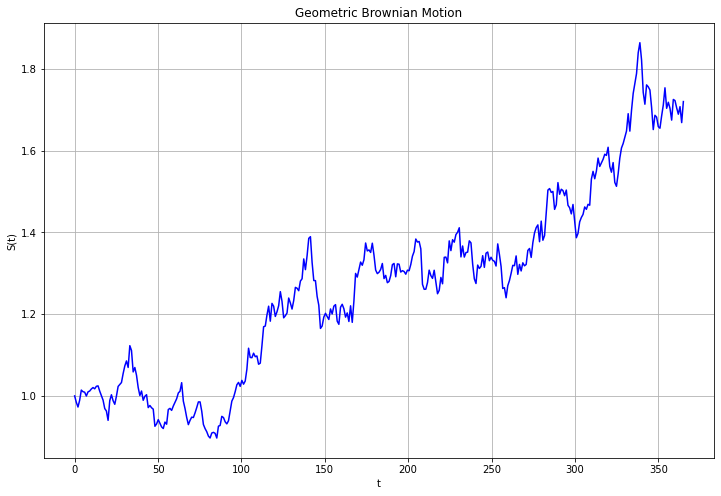

In [5]:
# Plot of Geometric Brownian Motion
mu = 0.002
sigma = 0.02
x0 = 1
dt = 1
T = 365

x = np.linspace(0,T,int(T/dt))
GBM = GeometricBrownianMotion(mu,sigma,x0,dt,T)

plt.figure(figsize=(12,8))
plt.plot(x, GBM, color='blue')
plt.grid()
plt.xlabel('t')
plt.ylabel('S(t)')
plt.title('Geometric Brownian Motion')
plt.show()

In [6]:
# Simulating Stock Price
import numpy as np
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr
import pandas as pd
from datetime import date
import yfinance as yf
yf.pdr_override()

start_date = '2016-1-1'
end_date = '2019-11-29'
pred_end_date = '2020-1-1'

# data used to model the GBM
df = []
data = pdr.get_data_yahoo('AAPL', start=start_date, end='2019-11-30', progress=True)
df.append(data)
df = pd.concat(df)
df = df.reset_index()
stock = df[['Date','Adj Close']]

# data to compare the forecast of one month 
df = []
data = pdr.get_data_yahoo('AAPL', start=end_date, end=pred_end_date, progress=True)
df.append(data)
df = pd.concat(df)
df = df.reset_index()
stock_m = df[['Date','Adj Close']]

returns = np.log(stock['Adj Close']/stock['Adj Close'].shift(1))
returns[0] = 0

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


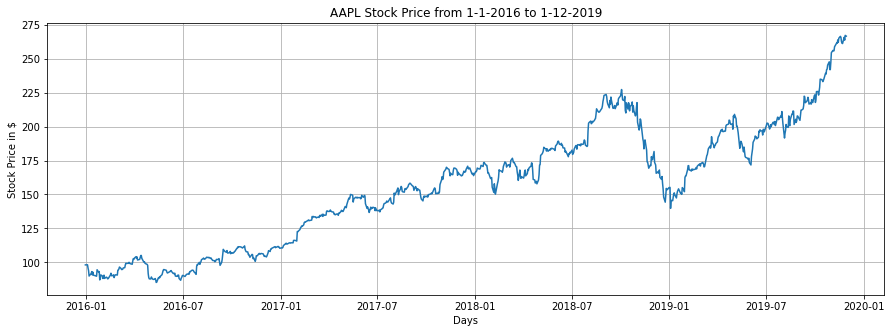

In [7]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

plt.figure(figsize = (15, 5))
plt.plot(stock['Date'],stock['Adj Close'])
plt.xlabel('Days')
plt.ylabel('Stock Price in $')
plt.title('AAPL Stock Price from 1-1-2016 to 1-12-2019')
plt.grid()
plt.show()

In [8]:
# Parameter Definitions

# So : initial stock price
S0 = stock.loc[stock.shape[0] - 1, 'Adj Close']

# dt : time increment (not sure)
dt = 1

# T : length of the prediction time horizon (how many time points to predict, same unit with dt(days))
n_of_wkdays = pd.date_range(start = pd.to_datetime(end_date, 
              format = "%Y-%m-%d") + pd.Timedelta('1 days'), 
              end = pd.to_datetime(pred_end_date, 
              format = "%Y-%m-%d")).to_series(
              ).map(lambda x: 1 if x.isoweekday() in range(1,6) else 0).sum()
T = n_of_wkdays - 1

# N : number of time points in the prediction time horizon N = T/dt
# t : array for time points in the prediction time horizon [1, 2, 3, .. , N] t = np.arange(1, int(N) + 1)

# sigma : standard deviation of historical daily returns
sigma_r = np.std(returns)

# mu : mean of historical daily returns
mu_r = np.mean(returns)

# estimator
sigma = sigma_r
mu = mu_r + 1 / 2 * sigma_r ** 2
print(round(mu,3),round(sigma,3))

# nb_scen : number of simulated scenarios
nb_scen = 100

# GB : array for geometric brownian paths
GB = []
for scen in range(nb_scen):
    GB.append(GeometricBrownianMotion(mu,sigma,S0,dt,T))

0.001 0.015


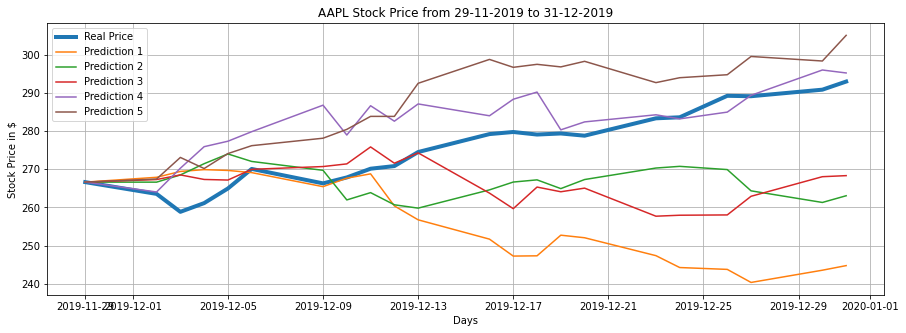

In [9]:
# Plot of the prediction
plt.figure(figsize = (15, 5))

plt.plot(stock_m['Date'],stock_m['Adj Close'], label='Real Price', linewidth=4)

for i in range(5):
    plt.plot(stock_m['Date'], GB[i], label='Prediction ' + str(i+1))
    #plt.plot(pd.date_range(start = end_date, end = pred_end_date, freq = 'D').map(lambda x: 
    #x if x.isoweekday() in range(1, 6) else np.nan).dropna(),
    #GB[i], label='Prediction ' + str(i+1))
    
plt.xlabel('Days')
plt.ylabel('Stock Price in $')
plt.title('AAPL Stock Price from 29-11-2019 to 31-12-2019')
plt.legend()
plt.grid()
SaveFig('AAPL-Stock-Price-Prediction-GBM-December-2019')
plt.show()

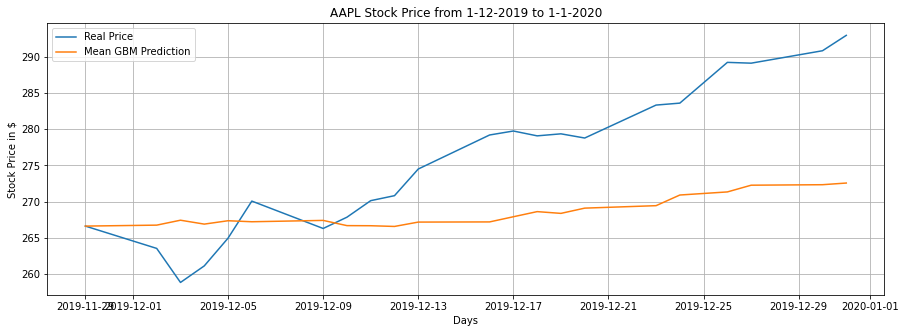

In [10]:
# Mean GBM prediction
mean_GB = pd.DataFrame(GB, columns=stock_m['Date']).mean(axis=0)

plt.figure(figsize = (15, 5))
plt.plot(stock_m['Date'],stock_m['Adj Close'], label='Real Price')
plt.plot(stock_m['Date'],mean_GB, label='Mean GBM Prediction')
plt.xlabel('Days')
plt.ylabel('Stock Price in $')
plt.title('AAPL Stock Price from 1-12-2019 to 1-1-2020')
plt.legend()
plt.grid()
SaveFig('AAPL-Stock-Price-Prediction-Mean-GBM-December-2019')
plt.show()